title: Summary of the discrepancies between total visits in A/B tests from Optimizely and Snowplow FE tracking 
author: Joao Fernandes 
date: 2022-11-29 
region: EU 
tags: acquire, data quality, snowplow, AB tests, optimizely, upper funnel 
summary: Optimizely counts many more visitors than we see in Snowplow. Some difference is to be expected due to adblockers and data loss at the Snowplow enricher, but this seems excessive. This discrepancy is not stable across experiments, but instead varies quite significantly. We also see that for some users (as identified by domain_userid) we are sending events to optimizely with more than one uniqueDeviceToken - this likely leads to overcounting by Optimizely, but happens too rarely to fully explain the discrepancies observed.

## Context

The Upper Funnel team has integrated Optimizely in the website (n26.com domain). We would like to benchmark the tool against our existing frontend tracking data.

Four tests have been run so far on the website, with two of them being AA tests:
- aa test 1
- mobile hero (documentation [here](https://docs.google.com/document/d/1bN-kw504BPINm0ili5-d54AVbZK-HvznHZdC5HheQD0/edit))
- account overview (documentation [here](https://docs.google.com/document/d/1wlxzH7Pzd_6i8gU-UlXX8ZTgDuCXibfBKOGLWWbrEaM/edit#heading=h.d7w72c4ouia))
- aa test 2


Ideally, we would like to compare the total number of visits, total number of conversions and conversion rates calculated by optimizely with the ones we compute from our Snowplow data. Up until now, because we didn't track in Snowplow the conversion events being tracked by Optimizely (primarily the Open Bank Account CTA button clicks) we are limited to comparing the total number of visitors. (Snowplow tracking for this CTA button click has since been implemented, so in upcoming tests we plan on also comparing conversions).

We have three data sources here:
- The Optimizely results
- Events that are sent in duplicate to Snowplow from the website BE (the same events are sent to Snowplow and to Optimizely and are the basis for the Optimizely results). These should not be affected by adblockers.
- Our regular Snowplow tracking events (FE)

Optimizely computes its total number of visitors the following way:
- Users visiting a page multiple times within the same day are counted once (starting and ending at midnight): 
    - if a user visits a page at 10:00 and then again on the same day at 22:00, they will be counted once
    - if a user visits a page at 23h59 and then again at 00h01, they will be counted twice
- Users visiting a version of the same page in a different language/locale within the same day are counted only once:
    - if a user visits `/en-de/free-bank-account` and swtiches to `/de-de/kostenloses-girokonto`, this will be counted once
    
In order to make the numbers comparable, we calculated the total number of visits from snowplow the same way as Optimizely does.

First, let's get all the data.

## Importing all the goodies we need

In [1]:
%%capture
!pip install matplotlib
!pip install seaborn

In [2]:
import warnings

warnings.filterwarnings("ignore")
from utils.datalib_database import df_from_sql

import pandas as pd
import numpy as np

pd.options.display.float_format = "{:,.2f}".format

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Getting the data

#### FE data (Snowplow tracking)
(this is what we in the UF team have been informally calling the domain_userid query)

In [3]:
def fe_query_formatted(start_date, end_date, urls, breakdown, extra_conditions=""):
    if type(urls) == list and len(urls) > 1:
        urls = ", ".join(["'" + i + "'" for i in urls])
    else:
        urls = "'" + urls + "'"

    cte = f"""with base as (
        select
            date_trunc('day', collector_tstamp) as dt,
            count(distinct domain_userid) as daily_unique_visitors
        from dbt.zrh_web_traffic_channel
        where
              collector_tstamp >= '{start_date}'::timestamp
          and collector_tstamp < '{end_date}'::timestamp + interval '1 day'
          and page_urlpath in ({urls})
          {extra_conditions}
        group by 1
        )"""

    if breakdown == "total":
        main_query = (
            "select sum(daily_unique_visitors) as cum_daily_unique_visitors from base"
        )
    elif breakdown in ["month", "week", "day"]:
        main_query = f"""
        select date_trunc('{breakdown}', dt), sum(daily_unique_visitors) as cum_daily_unique_visitors 
        from base
        group by 1
        order by 1
        """
    else:
        return "Please provide a breakdown from total, month, week, day"
    return cte + " " + main_query

In [4]:
aa_test_1 = [
    "2022.06.15",
    "2022.06.30",
    ["/en-de/free-bank-account", "/de-de/kostenloses-girokonto"],
    "total",
    "",
]
account_overview = ["2022.08.15", "2022.08.28", ["/en-de", "/de-de"], "total", ""]
mobile_hero = [
    "2022.08.29",
    "2022.09.11",
    ["/en-de", "/de-de"],
    "total",
    "and dvce_type = 'Mobile'",
]
aa_test_2 = ["2022.09.14", "2022.09.19", ["/en-de", "/de-de"], "total", ""]

df_fe = pd.DataFrame([aa_test_1, account_overview, mobile_hero, aa_test_2])
df_fe.columns = ["start_date", "end_date", "urls", "breakdown", "other_conditions"]
df_fe.index = ["aa_test_1", "account_overview", "mobile_hero", "aa_test_2"]

df_fe

,start_date,end_date,urls,breakdown,other_conditions
aa_test_1,2022.06.15,2022.06.30,"[/en-de/free-bank-account, /de-de/kostenloses-...",total,
account_overview,2022.08.15,2022.08.28,"[/en-de, /de-de]",total,
mobile_hero,2022.08.29,2022.09.11,"[/en-de, /de-de]",total,and dvce_type = 'Mobile'
aa_test_2,2022.09.14,2022.09.19,"[/en-de, /de-de]",total,


In [5]:
total_visits_fe = {}
for i in df_fe.index:
    total_visits_fe[i] = df_from_sql(
        "redshiftreader",
        fe_query_formatted(
            df_fe.loc[i].start_date,
            df_fe.loc[i].end_date,
            df_fe.loc[i].urls,
            df_fe.loc[i].breakdown,
            df_fe.loc[i].other_conditions,
        ),
    ).loc[0, "cum_daily_unique_visitors"]

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20221129T092544", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "4a7818c5-21d2-40ff-a820-120ddfe95ef5", "hostname": "172.18.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 4.8747, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20221129T092549", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "4a7818c5-21d2-40ff-a820-120ddfe95ef5", "hostname": "172.18.0.4"}
{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "

In [6]:
total_visits_fe

{'aa_test_1': 14274,
 'account_overview': 75079,
 'mobile_hero': 32830,
 'aa_test_2': 36148}

#### BE events 
(this is what we in the UF team have been informally calling the UUID query)

In [7]:
def be_query_formatted(start_date, end_date, experiment_key, breakdown):
    cte = f"""with base as (
        select
            date_trunc('day', collector_date),
            count(distinct json_extract_path_text(se_label, 'uniqueDeviceToken')) as unique_daily_visitors
        from dbt.snowplow
        where se_action = 'optimizely_activate'
        and json_extract_path_text(se_label, 'experimentKey') = '{experiment_key}'
        and collector_date>='2022.06.15'
        and collector_date between '{start_date}' and '{end_date}'
        group by 1) """

    if breakdown == "total":
        main_query = (
            "select sum(unique_daily_visitors) as cum_daily_unique_visitors from base"
        )
    else:
        main_query = f"""select date_trunc({breakdown}, sum(unique_daily_visitors) as cum_daily_unique_visitors
        from base
        group by 1
        order by 1
        )"""

    return cte + main_query

In [8]:
aa_test_1 = ["2022.06.15", "2022.06.30", "aa_1_free_bank_account_de_sui-6", "total"]
account_overview = ["2022.08.15", "2022.08.28", "account_overview", "total"]
mobile_hero = ["2022.08.29", "2022.09.11", "uf_002_mobile_hero", "total"]
aa_test_2 = ["2022.09.14", "2022.09.19", "aa_test_2", "total"]

In [9]:
df_be = pd.DataFrame([aa_test_1, account_overview, mobile_hero, aa_test_2])

df_be.columns = ["start_date", "end_date", "experiment_key", "breakdown"]
df_be.index = ["aa_test_1", "account_overview", "mobile_hero", "aa_test_2"]

df_be

,start_date,end_date,experiment_key,breakdown
aa_test_1,2022.06.15,2022.06.30,aa_1_free_bank_account_de_sui-6,total
account_overview,2022.08.15,2022.08.28,account_overview,total
mobile_hero,2022.08.29,2022.09.11,uf_002_mobile_hero,total
aa_test_2,2022.09.14,2022.09.19,aa_test_2,total


In [10]:
total_visits_be = {}
for i in df_be.index:
    total_visits_be[i] = df_from_sql(
        "redshiftreader",
        be_query_formatted(
            df_be.loc[i].start_date,
            df_be.loc[i].end_date,
            df_be.loc[i].experiment_key,
            df_be.loc[i].breakdown,
        ),
    ).loc[0, "cum_daily_unique_visitors"]

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20221129T092610", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "4a7818c5-21d2-40ff-a820-120ddfe95ef5", "hostname": "172.18.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 6.8603, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20221129T092616", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "4a7818c5-21d2-40ff-a820-120ddfe95ef5", "hostname": "172.18.0.4"}
{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "

In [11]:
total_visits_be

{'aa_test_1': 24152,
 'account_overview': 342079,
 'mobile_hero': 165220,
 'aa_test_2': 127789}

#### Optimizely results

In [12]:
total_visits_opti = {
    "aa_test_1": 24599,
    "account_overview": 348683,
    "mobile_hero": 172669,
    "aa_test_2": 126403,
}

## Results

#### Putting it all together

In [41]:
results = pd.DataFrame(
    [total_visits_fe, total_visits_be, total_visits_opti]
).transpose()
results.columns = ["FE total visits", "BE total visits", "Optimizely total visits"]

results["FE vs Optimizely diff"] = (
    results["FE total visits"] / results["Optimizely total visits"] * 100
)
results["BE vs Optimizely diff"] = (
    results["BE total visits"] / results["Optimizely total visits"] * 100
)

results

,FE total visits,BE total visits,Optimizely total visits,FE vs Optimizely diff,BE vs Optimizely diff
aa_test_1,14274,24152,24599,58.03,98.18
account_overview,75079,342079,348683,21.53,98.11
mobile_hero,32830,165220,172669,19.01,95.69
aa_test_2,36148,127789,126403,28.60,101.10


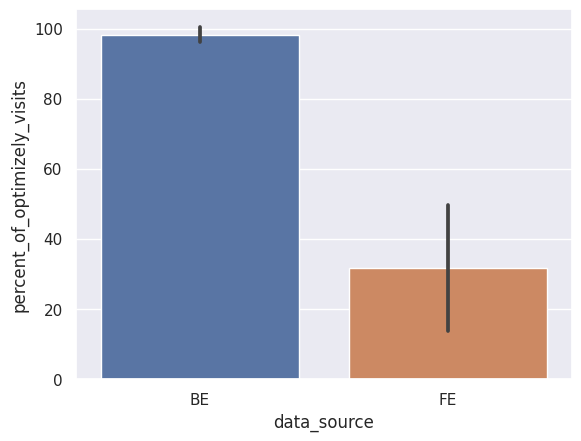

In [42]:
results_sns_format = pd.DataFrame(["BE"] * 4 + ["FE"] * 4)
results_sns_format.columns = ["data_source"]

results_sns_format["percent_of_optimizely_visits"] = list(
    results["BE vs Optimizely diff"]
) + list(results["FE vs Optimizely diff"])

sns.barplot(
    data=results_sns_format,
    x="data_source",
    y="percent_of_optimizely_visits",
    errorbar="sd",
);

We see that the total daily unique visitors computed by Optimizely match closely what we calculate based on the events sent in duplicate from the BE. This is what we would expect.

We also observe that the visitor counts based on our snowplow tracking are much lower than the ones Optimizely computes. We expected to see fewer visitors in Snowplow, given that Snowplow data is incomplete. There are two main reasons for this that we can think of:
- some adblockers might prevent snowplow data from being tracked
- we might lose events at the enricher (this step is not owned by anyone and is somewhat of a black box at the moment)

However, we did not expect the difference to be this large. Additionally, we would expect this data loss to be more or less stable across different experiments, but it is highly variable - compare the difference between the AA test 1 and the Mobile Hero test, for example. 

One possible factor that was suggested to influence this difference initially was the experiment complexity in terms of how many variation containers were involved. This was suggested because the Mobile Hero and Account Overview tests were quite complex, unlike the AA test 1 which was simpler. However, the second AA test, whic was also quite simple, did not confirm this hypothesis, so this doesn't seem to be a major factor.

Manual testing by Bledi suggested that the events were being sent to optimizely and counted correctly.

## Additional insights from BE events since they started to be sent with domain_userid

Since 2022.10.19 the BE events being sent in duplicate to snowplow also contain the domain_userid. Previously they were sent only with uniqueDeviceToken in the JSON in the se_label; this is still the user identifier that Optimizely uses to distinguish users. A dummy test was set up to follow this up. This allowed for some additional insights.

In [18]:
query_1 = """
with base as (select
                  date_trunc('day', collector_tstamp) as dt,
                  case
                      when se_label like '%path%' then 'path'
                      when se_label like '%pagePath%' then 'pagePath'
                      else 'weird'
                      end as path_variable_name,
                  case when se_label like '%domainUserId%' then 1 else 0 end as contains_id_in_label,
                  case when domain_userid is not null then 1 else 0 end as contains_id_in_field
              from etl_reporting.snowplow_enriched
              where
                    se_action = 'optimizely_activate'
                and collector_tstamp >= '2022.10.15'
                and se_label like '%_signup_test__signup_kyc_events_test%')
select
    dt,
    path_variable_name,
    count(*),
    sum(contains_id_in_label),
    sum(contains_id_in_field),
    count(case when contains_id_in_label = 1 and contains_id_in_field = 1 then 1 end) as contains_id_in_both,
    count(case when contains_id_in_label = 0 and contains_id_in_field = 1 then 1 end) as contains_id_in_fied_only,
    count(case when contains_id_in_label = 1 and contains_id_in_field = 0 then 1 end) as contains_id_in_label_only
from base
group by 1, 2
order by 1, 2"""

query_1_results = df_from_sql("redshiftreader", query_1)
query_1_results

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20221129T092656", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "4a7818c5-21d2-40ff-a820-120ddfe95ef5", "hostname": "172.18.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 26.6628, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20221129T092722", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "4a7818c5-21d2-40ff-a820-120ddfe95ef5", "hostname": "172.18.0.4"}


,dt,path_variable_name,count,sum,sum,contains_id_in_both,contains_id_in_fied_only,contains_id_in_label_only
0,2022-10-15,pagePath,100,0,41,0,41,0
1,2022-10-15,path,91,0,11,0,11,0
2,2022-10-16,pagePath,89,0,34,0,34,0
3,2022-10-16,path,83,0,16,0,16,0
4,2022-10-17,pagePath,110,0,57,0,57,0
5,2022-10-17,path,81,0,17,0,17,0
6,2022-10-18,pagePath,91,0,34,0,34,0
7,2022-10-18,path,66,0,14,0,14,0
8,2022-10-19,pagePath,118,33,40,32,8,1
9,2022-10-19,path,86,9,16,9,7,0


Not all events were being sent with domain_userid, but the ones that were have it on both the domain_userid column in snowplow and also in the JSON payload in the se_label since the release day (a few odd cases happened during the day of the release but that hasn't happened again).

In [19]:
query_2 = """
with base as (select
                  collector_tstamp,
                  domain_userid,
                  case
                      when se_label like '%path%' then 1
                      else 0
                      end as var_path,
                  case
                      when se_label like '%pagePath%' then 1
                      else 0
                      end as var_pagePath,
                  lead(collector_tstamp, 1) over (partition by domain_userid order by collector_tstamp) as next_event,
                  date_diff('second', collector_tstamp, next_event) as date_diff
              from etl_reporting.snowplow_enriched
              where
                    se_action = 'optimizely_activate'
                and collector_tstamp >= '2022.10.17'
                and se_label like '%_signup_test__signup_kyc_events_test%'
                and domain_userid is not null
              order by domain_userid, collector_tstamp)
select
    date_trunc('day', collector_tstamp),
    count(distinct domain_userid) as n_users,
    count(distinct case when date_diff <= 1 then domain_userid end) as n_users_with_repeated_events,
    100.0 * n_users_with_repeated_events / n_users as percent_users_with_repeated_events
from base
group by 1
order by 1
"""

query_2_results = df_from_sql("redshiftreader", query_2)
query_2_results

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20221129T092723", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "4a7818c5-21d2-40ff-a820-120ddfe95ef5", "hostname": "172.18.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 11.2913, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20221129T092735", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "4a7818c5-21d2-40ff-a820-120ddfe95ef5", "hostname": "172.18.0.4"}


,date_trunc,n_users,n_users_with_repeated_events,percent_users_with_repeated_events
0,2022-10-17,49,15,30.61
1,2022-10-18,35,11,31.43
2,2022-10-19,43,13,30.23
3,2022-10-20,57,14,24.56
4,2022-10-21,50,18,36.00
5,2022-10-22,38,13,34.21
6,2022-10-23,36,12,33.33
7,2022-10-24,43,5,11.63
8,2022-10-25,61,20,32.79
9,2022-10-26,34,11,32.35


Around a third of all users have duplicated events, one with a `path` variable and another with a `pagePath` variable in the JSON in the se_label. This shouldn't affect any of the numbers from before but should be fixed.

In [20]:
query_3 = """
with base as (select
                  collector_tstamp,
                  domain_userid,
                  json_extract_path_text(se_label, 'uniqueDeviceToken') as uniqueDeviceToken
              from etl_reporting.snowplow_enriched
              where
                    se_action = 'optimizely_activate'
                and collector_tstamp >= '2022.10.17'
                and se_label like '%_signup_test__signup_kyc_events_test%'
                and domain_userid is not null
              order by domain_userid, collector_tstamp),
     base2 as (select
                   domain_userid,
                   count(distinct uniqueDeviceToken) as n_tokens
               from base
               group by 1)
select
    n_tokens,
    count(distinct domain_userid)
from base
    join base2 using (domain_userid)
group by 1
order by 1
"""

query_3_results = df_from_sql("redshiftreader", query_3)
query_3_results

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20221129T092736", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "4a7818c5-21d2-40ff-a820-120ddfe95ef5", "hostname": "172.18.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 29.5221, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20221129T092805", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "4a7818c5-21d2-40ff-a820-120ddfe95ef5", "hostname": "172.18.0.4"}


,n_tokens,count
0,1,656
1,2,25
2,3,2


Around 4.7% of domain_userids have more than one uniqueDeviceToken. This is concerning, as it would lead to overcounting by Optimizely, as it relies on these identifiers to distinguish individual users. It certainly does not explain the much larger discrepancy we saw before, but is likely contributing to it and needs to be further investigated. 

In [21]:
query_4 = """
select
    'optimizely events' as flag,
    count(distinct domain_userid) as n_visitors
from etl_reporting.snowplow_enriched
where
      se_action = 'optimizely_activate'
  and collector_tstamp >= '2022.10.18'
  and se_label like '%_signup_test__signup_kyc_events_test%'
  and collector_tstamp < date_trunc('day', getdate())

union all

select
    'snowplow events' as flag,
    count(distinct domain_userid) as n_visitors
from dbt.zrh_web_traffic_channel
where
      page_urlpath in ('/en-de/insurance', '/de-de/versicherung')
  and collector_tstamp >= '2022.10.18'
  and collector_tstamp <= '2022.11.02'"""

query_4_results = df_from_sql("redshiftreader", query_4)
query_4_results

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20221129T092807", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "4a7818c5-21d2-40ff-a820-120ddfe95ef5", "hostname": "172.18.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 215.2395, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20221129T093142", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "4a7818c5-21d2-40ff-a820-120ddfe95ef5", "hostname": "172.18.0.4"}


,flag,n_visitors
0,optimizely events,637
1,snowplow events,593


We see around 9.3% fewer distinct domain_userids with our regular snowplow tracking than we see optimizely events with domain_userid. 
According to Margarita, this is probably the same percentage of users that we are missing data for due to the adblocker issue.